In [1]:

from pathlib import Path
import numpy as np
import pandas as pd
import os
from utils import *

In [2]:
data_path = Path(os.getcwd()) # perhaps set to external harddrive to accomodate large amount of data
path = data_path / 'stock price data'/"company stock price daily"/'AAPL.csv'
stock = pd.read_csv(path)
stock['date'] = pd.to_datetime(stock['date'])
stock = stock.sort_values(by='date').reset_index(drop=True) 
stock

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime,Symbol
0,2010-01-04,7.6225,7.6607,7.5850,7.6432,6.496293,493719800,17632850,0.0207,0.27156,7.63,"January 04, 10",0.002716,AAPL
1,2010-01-05,7.6643,7.6996,7.6161,7.6564,6.507526,601901216,21496472,-0.0079,-0.10308,7.67,"January 05, 10",-0.001031,AAPL
2,2010-01-06,7.6564,7.6868,7.5268,7.5346,6.404015,552158376,19719942,-0.1218,-1.59000,7.61,"January 06, 10",-0.015900,AAPL
3,2010-01-07,7.5625,7.5714,7.4661,7.5207,6.392176,477129296,17040332,-0.0418,-0.55273,7.51,"January 07, 10",-0.005527,AAPL
4,2010-01-08,7.5107,7.5714,7.4664,7.5707,6.434673,447872124,15995433,0.0600,0.79886,7.53,"January 08, 10",0.007989,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,2023-07-05,191.5650,192.9800,190.6200,191.3300,191.330002,46896861,46920300,-0.2350,-0.12267,191.58,"July 05, 23",-0.001227,AAPL
3398,2023-07-06,189.8400,192.0200,189.2000,191.8100,191.809998,45155523,45094300,1.9700,1.04000,190.82,"July 06, 23",0.010400,AAPL
3399,2023-07-07,191.4100,192.6700,190.2400,190.6800,190.679993,46757498,46778000,-0.7300,-0.38138,191.42,"July 07, 23",-0.003814,AAPL
3400,2023-07-10,189.2600,189.9900,187.0350,188.6100,188.610001,59912163,59922200,-0.6500,-0.34344,188.36,"July 10, 23",-0.003434,AAPL


In [3]:
#Trend Indicator A-V2.2 [Dziwne]
def pine_ema(data, length):
    """
    Calculate the Exponential Moving Average (EMA) equivalent to the Pine Script function.
    :param data: Pandas Series containing the data to calculate EMA on (e.g., close prices).
    :param length: The length of the EMA.
    :return: Pandas Series containing the calculated EMA.
    """
    alpha = 2 / (length + 1)
    ema_values = [np.nan for i in range(data.isna().sum())]
    data_new = data.dropna()
    # Calculate the first EMA value using SMA (Simple Moving Average)
    first_ema = data_new.rolling(window=length).mean().iloc[length - 1]

    # Initialize a list to store EMA values
    ema_values.append(first_ema)

    # Calculate the rest of the EMA values
    for price in data_new.iloc[length:]:
        new_ema = alpha * price + (1 - alpha) * ema_values[-1]
        ema_values.append(new_ema)

    # Fill the initial part with NaN
    ema_series = pd.Series([np.nan] * (length - 1) + ema_values, index=data.index)
    return ema_series

def pine_sma(data, length):
    """
    Calculate the Simple Moving Average (SMA) equivalent to the Pine Script function.
    :param data: Pandas Series containing the data to calculate SMA on.
    :param length: The length of the SMA calculation period.
    :return: Pandas Series containing the calculated SMA.
    """
    return data.rolling(window=length).mean()

ma_type = "EMA"
ma_period = 52
ma_period_smoothing = 10
def moving_average(type, source, period, volume=None):
    if type == "EMA":
        return pine_ema(source, period)
    elif type == "SMA":
        return source.rolling(window=period).mean()
    elif type == "SWMA":
        # Symmetrically weighted moving average
        weights = np.array([1/6, 2/6, 2/6, 1/6])
        return source.rolling(window=4).apply(lambda x: np.dot(x, weights), raw=True)
    elif type == "VWMA":
        # Volume Weighted Moving Average
        return (source * volume).rolling(window=period).sum() / volume.rolling(window=period).sum()
    elif type == "WMA":
        # Weighted Moving Average
        weights = np.arange(1, period + 1)
        return source.rolling(window=period).apply(lambda x: np.dot(x, weights[::-1]) / weights.sum(), raw=True)

# Re-calculate the moving averages with the updated function
stock['o_ma'] = moving_average(ma_type, stock['open'], ma_period, stock['volume'])
stock['c_ma'] = moving_average(ma_type, stock['close'], ma_period, stock['volume'])
stock['h_ma'] = moving_average(ma_type, stock['high'], ma_period, stock['volume'])
stock['l_ma'] = moving_average(ma_type, stock['low'], ma_period, stock['volume'])
stock['o_ma'].fillna(stock["open"], inplace=True)
stock['c_ma'].fillna(stock["close"], inplace=True)
stock['h_ma'].fillna(stock["high"], inplace=True)
stock['l_ma'].fillna(stock["low"], inplace=True)
# Re-calculate Heikin Ashi and smoothed values
stock["ha_o"] = (stock['o_ma'] + stock['c_ma']) / 2
stock['ha_c'] = (stock['o_ma'] + stock['h_ma'] + stock['l_ma'] + stock['c_ma']) / 4
for i in range(len(stock)):
    if i!=0:
        stock.loc[i,"ha_o"] = (stock.loc[i-1,"ha_o"] + stock.loc[i-1,"ha_c"])/2
# stock['ha_o'] = (stock['ha_o'].shift(1).fillna(stock['ha_o']) + stock['ha_c'].shift(1).fillna(stock['ha_c']))/2
stock['ha_h'] = stock[['h_ma', 'ha_o', 'ha_c']].max(axis=1)
stock['ha_l'] = stock[['l_ma', 'ha_o', 'ha_c']].min(axis=1)

stock['ha_o_smooth'] = moving_average(ma_type, stock['ha_o'], ma_period_smoothing, stock['volume'])
stock['ha_c_smooth'] = moving_average(ma_type, stock['ha_c'], ma_period_smoothing, stock['volume'])
stock['ha_h_smooth'] = moving_average(ma_type, stock['ha_h'], ma_period_smoothing, stock['volume'])
stock['ha_l_smooth'] = moving_average(ma_type, stock['ha_l'], ma_period_smoothing, stock['volume'])

# Update Trend Determination
stock['trend'] = stock.apply(lambda row: 1 if row['ha_c_smooth'] >= row['ha_o_smooth'] else -1, axis=1)

# Display the updated dataframe
stock.tail()

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,...,l_ma,ha_o,ha_c,ha_h,ha_l,ha_o_smooth,ha_c_smooth,ha_h_smooth,ha_l_smooth,trend
3397,2023-07-05,191.565,192.98,190.620,191.33,191.330002,46896861,46920300,-0.235,-0.12267,...,176.651906,176.794428,177.920964,179.246464,176.651906,174.503033,175.541092,176.879421,174.249763,1
3398,2023-07-06,189.840,192.02,189.200,191.81,191.809998,45155523,45094300,1.970,1.04000,...,177.125419,177.357696,178.403852,179.728484,177.125419,175.022062,176.061594,177.397432,174.772609,1
3399,2023-07-07,191.410,192.67,190.240,190.68,190.679993,46757498,46778000,-0.730,-0.38138,...,177.620309,177.880774,178.888612,180.216843,177.620309,175.541828,176.575597,177.910052,175.290373,1
3400,2023-07-10,189.260,189.99,187.035,188.61,188.610001,59912163,59922200,-0.650,-0.34344,...,177.975580,178.384693,179.259750,180.585642,177.975580,176.058713,177.063625,178.396523,175.778592,1
3401,2023-07-11,189.160,189.30,186.600,188.08,188.080002,46522493,46509718,-1.080,-0.57095,...,178.301030,178.822221,179.600325,180.914485,178.301030,176.561169,177.524843,178.854335,176.237217,1


In [4]:
def pine_rma(data, length):
    """
    Calculate the Rolling Moving Average (RMA) equivalent to the Pine Script function.
    :param data: Pandas Series containing the data to calculate RMA on (e.g., close prices).
    :param length: The length of the RMA.
    :return: Pandas Series containing the calculated RMA.
    """
    alpha = 1 / length

    # Initialize the RMA series with NaN values
    rma = pd.Series(index=data.index)

    # Calculate the first RMA value using SMA (Simple Moving Average)
    first_rma = data.rolling(window=length).mean().iloc[length - 1]
    rma.iloc[length - 1] = first_rma

    # Calculate the rest of the RMA values
    for i in range(length, len(data)):
        rma.iloc[i] = alpha * data.iloc[i] + (1 - alpha) * rma.iloc[i - 1]

    return rma

length = 9  # ATR Period
mult = 3.9  # ATR Multiplier
wicks = True  # Whether to take wicks into account

# Calculate True Range and Average True Range (ATR)
stock['tr0'] = abs(stock['high'] - stock['low'])
stock['tr1'] = abs(stock['high'] - stock['close'].shift())
stock['tr2'] = abs(stock['low'] - stock['close'].shift())
stock['tr'] = stock[['tr0', 'tr1', 'tr2']].max(axis=1)
stock['atr'] = pine_rma(stock['tr'], length)

# Calculate highPrice and lowPrice based on wicks
stock['highPrice'] = stock['high'] if wicks else stock['close']
stock['lowPrice'] = stock['low'] if wicks else stock['close']

# Source (hl2)
stock['src'] = (stock['high'] + stock['low']) / 2

# Determine if the current candlestick is a Doji
stock['doji4price'] = (stock['open'] == stock['close']) & (stock['open'] == stock['low']) & (stock['open'] == stock['high'])

# Long and Short Stop Calculation
stock['longStop'] = stock['src'] - mult * stock['atr']

for i in range(1, len(stock)):
    if i==1:
        stock.loc[i,'longStopPrev'] = stock.loc[i,'longStop']
    else:
        stock.loc[i,'longStopPrev'] = stock.loc[i-1,'longStop']
    if stock.loc[i-1, "close"] > stock.loc[i-1, "longStopPrev"]:
        stock.loc[i,'longStop'] = max(stock['longStop'][i], stock['longStopPrev'][i])

stock['shortStop'] = stock['src'] + mult * stock['atr']

for i in range(1, len(stock)):
    if i==1:
        stock.loc[i,'shortStopPrev'] = stock.loc[i,'shortStop']
    else:
        stock.loc[i,'shortStopPrev'] = stock.loc[i-1,'shortStop']
    if stock.loc[i-1, "close"] < stock.loc[i-1, "shortStopPrev"]:
        stock.loc[i,'shortStop'] = min(stock['shortStop'][i], stock['shortStopPrev'][i])

# Trend Calculation
stock['dir'] = 1
for i in range(1, len(stock)):
    if stock['dir'][i-1] == -1 and stock['close'][i] > stock['shortStopPrev'][i]:
        stock.at[i, 'dir'] = 1
    elif stock['dir'][i-1] == 1 and stock['close'][i] < stock['longStopPrev'][i]:
        stock.at[i, 'dir'] = -1
    else:
        stock.at[i, 'dir'] = stock['dir'][i-1]

In [5]:
def pine_rsi(data, period):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = pine_rma(gain, period)
    avg_loss = pine_rma(loss, period)
    rs = avg_gain/avg_loss
    rsi = 100-(100/(1+rs))
    return rsi

def pine_cross(data1, data2):
    data1_prev = data1.shift(1)
    data2_prev = data2.shift(1)
    return ((data1 > data2) & (data1_prev <= data2_prev))

def pine_sma(data, length):
    return data.rolling(window=length).mean()

def pine_stdev(src, length):
    return src.rolling(window=length).std(ddof=0)

rsi_period = 6
sf = 5
qqe = 3
thres = 3
src = "close"
wilders_period = rsi_period * 2 - 1

stock["rsi"] = pine_rsi(stock[src], rsi_period)
stock["rsi_ma"] = pine_ema(stock["rsi"], sf)
stock["AtrRsi"] = abs(stock["rsi_ma"].shift(1) - stock["rsi_ma"])
stock["MaAtrRsi"] = pine_ema(stock["AtrRsi"], wilders_period)
stock["dar"] = pine_ema(stock["MaAtrRsi"], wilders_period) *qqe

# DeltaFastAtrRsi = dar
# RSIndex = RsiMa
stock["newshortband"] = stock["rsi_ma"] + stock["dar"]
stock["newlongband"] = stock["rsi_ma"] - stock["dar"]
for i in range(len(stock)):
    if i<stock["newlongband"].isna().sum():
        continue
    elif i == stock["newlongband"].isna().sum():
        stock.loc[i, "longband"] = stock.loc[i, "newlongband"]
        stock.loc[i, "shortband"] = stock.loc[i, "newshortband"]
    else:
        if stock["rsi_ma"][i-1] > stock["longband"][i-1] and stock["rsi_ma"][i] > stock["longband"][i-1]:
            stock.loc[i, "longband"] = max(stock["newlongband"][i], stock["longband"][i-1])
        else:
            stock.loc[i, "longband"] = stock.loc[i, "newlongband"]
        if stock["rsi_ma"][i-1] < stock["shortband"][i-1] and stock["rsi_ma"][i] < stock["shortband"][i-1]:
            stock.loc[i, "shortband"] = min(stock["newshortband"][i], stock["shortband"][i-1])
        else:
            stock.loc[i, "shortband"] = stock.loc[i, "newshortband"]

cross_1 = pine_cross(stock["longband"].shift(1), stock["rsi_ma"])
cross_temp = pine_cross(stock["rsi_ma"],stock["shortband"].shift(1))
trend = pd.Series()
for i in range(len(cross_1)):
    if cross_temp[i]:
        trend[i] = 1
    elif cross_1[i]:
        trend[i]=-1
    else:
        if i == 0:
            trend[i] = 1
        else:
            trend[i] = trend[i-1]
    trend.fillna(1)
for i in range(len(trend)):
    if trend[i] == 1:
        stock.loc[i, "FastAtrRsiTL"] = stock["longband"][i]
    else:
        stock.loc[i, "FastAtrRsiTL"] = stock["shortband"][i]
##########

bb_length = 50
bb_mul = 0.35

basis = pine_sma(stock["FastAtrRsiTL"] - 50, bb_length)
dev = bb_mul * pine_stdev(stock["FastAtrRsiTL"] - 50, bb_length)
upper = basis + dev
lower = basis - dev

# #zero cross
# QQEzlong = pd.Series([0] * len(stock))
# QQEzshort = pd.Series([0] * len(stock))
# for i in range(1, len(QQEzlong)):
#     QQEzlong[i] = QQEzlong[i-1] + 1 if stock.loc[i, "rsi_ma"] >= 50 else 0
#     QQEzshort[i] = QQEzshort[i-1] + 1 if stock.loc[i, "rsi_ma"] < 50 else 0

########
rsi_period2 = 6
sf2 = 5
qqe2 = 1.61
thres2 = 3
src2 = "close"
wilders_period2 = rsi_period2 * 2 - 1

stock["rsi2"] = pine_rsi(stock[src2], rsi_period2)
stock["rsi_ma2"] = pine_ema(stock["rsi2"], sf2)
stock["AtrRsi2"] = abs(stock["rsi_ma2"].shift(1) - stock["rsi_ma2"])
stock["MaAtrRsi2"] = pine_ema(stock["AtrRsi2"], wilders_period2)
stock["dar2"] = pine_ema(stock["MaAtrRsi2"], wilders_period2) *qqe2

# stock["newshortband2"] = stock["rsi_ma2"] + stock["dar2"]
# stock["newlongband2"] = stock["rsi_ma2"] - stock["dar2"]
# for i in range(len(stock)):
#     if i<stock["newlongband2"].isna().sum():
#         continue
#     elif i == stock["newlongband2"].isna().sum():
#         stock.loc[i, "longband2"] = stock.loc[i, "newlongband2"]
#         stock.loc[i, "shortband2"] = stock.loc[i, "newshortband2"]
#     else:
#         if stock["rsi_ma2"][i-1] > stock["longband2"][i-1] and stock["rsi_ma2"][i] > stock["longband2"][i-1]:
#             stock.loc[i, "longband2"] = max(stock["newlongband2"][i], stock["longband2"][i-1])
#         else:
#             stock.loc[i, "longband2"] = stock.loc[i, "newlongband2"]
#         if stock["rsi_ma2"][i-1] < stock["shortband2"][i-1] and stock["rsi_ma2"][i] < stock["shortband2"][i-1]:
#             stock.loc[i, "shortband2"] = min(stock["newshortband2"][i], stock["shortband2"][i-1])
#         else:
#             stock.loc[i, "shortband2"] = stock.loc[i, "newshortband2"]

# cross_2 = pine_cross(stock["longband2"].shift(1), stock["rsi_ma2"])
# cross_temp2 = pine_cross(stock["rsi_ma2"],stock["shortband2"].shift(1), )
# trend2 = pd.Series()
# for i in range(len(cross_2)):
#     if cross_temp2[i]:
#         trend2[i] = 1
#     elif cross_2[i]:
#         trend2[i]=-1
#     else:
#         if i == 0:
#             trend2[i] = 1
#         else:
#             trend2[i] = trend2[i-1]
#     trend2.fillna(1)
# for i in range(len(trend2)):
#     if trend2[i] == 1:
#         stock.loc[i, "FastAtrRsi2TL"] = stock["longband2"][i]
#     else:
#         stock.loc[i, "FastAtrRsi2TL"] = stock["shortband2"][i]
# #zero cross
# QQE2zlong = pd.Series([0] * len(stock))
# QQE2zshort = pd.Series([0] * len(stock))
# for i in range(1, len(QQE2zlong)):
#     QQE2zlong[i] = QQE2zlong[i-1] + 1 if stock.loc[i, "rsi_ma2"] >= 50 else 0
#     QQE2zshort[i] = QQE2zshort[i-1] + 1 if stock.loc[i, "rsi_ma2"] < 50 else 0

####
stock["Greenbar1"] = stock["rsi_ma2"]-50 > thres2
stock["Greenbar2"] = stock["rsi_ma"]-50 > upper
stock["Redbar1"] = stock["rsi_ma2"]-50 <0 - thres2
stock["Redbar2"] = stock["rsi_ma"]-50 < lower

for i in range(len(stock)):
    if stock["Greenbar1"][i] == 1 and stock["Greenbar2"][i] == 1:
        stock.loc[i, "QQE Dir"] = stock["rsi_ma2"][i]-50
    elif stock["Redbar1"][i] == 1 and stock["Redbar2"][i] == 1:
        stock.loc[i, "QQE Dir"] = stock["rsi_ma2"][i]-50
    else:
        stock.loc[i, "QQE Dir"] = "Nan"

In [12]:

long = False
short = False
stop_loss_price = False
stop_loss=False
stop_gain=False
buy_price = False
for i in range(len(stock)):
    if i == 0:
        if stock.loc[i, "trend"] == 1 and stock.loc[i,"dir"] == 1 and (stock.loc[i, "QQE Dir"]!= "Nan" and stock.loc[i, "QQE Dir"] >=0) and stop_loss != "long" and stop_gain != "long":
            stock.loc[i, "order"] = 1
            long = True
            stop_loss = False
            stop_gain = False
            buy_price = stock.loc[i-1, "close"]
            stop_loss_price = stock.loc[i-1, "ha_o_smooth"]
        elif stock.loc[i, "trend"] == -1 and stock.loc[i,"dir"] == -1 and (stock.loc[i, "QQE Dir"]!= "Nan" and stock.loc[i, "QQE Dir"] <0) and stop_loss != "short" and stop_gain != "short":
            stock.loc[i, "order"] = -1
            long = True
            stop_loss = False
            stop_gain = False
            buy_price = stock.loc[i-1, "close"]
            stop_loss_price = stock.loc[i-1, "ha_o_smooth"]
        else:
            stock.loc[i, "order"] = 0
    else:
        if long:
            if stock.loc[i, "close"] <= stop_loss_price:
                stock.loc[i, "order"] = 0
                long = False
                stop_loss = "long"
                continue
            elif stock.loc[i, "close"] >= buy_price * 2 - stop_loss_price:
                stock.loc[i, "order"] = 0
                long = False
                # stop_gain = "long"
                continue
            # elif stock.loc[i, "trend"] != 1 or stock.loc[i,"dir"] != 1 or (stock.loc[i, "QQE Dir"]== "Nan" or stock.loc[i, "QQE Dir"] < 0):
            #     stock.loc[i, "order"] = 0
            #     long = False
            #     continue
        elif short:
            if stock.loc[i, "close"] >= stop_loss_price:
                stock.loc[i, "order"] = 0
                short = False
                stop_loss = "short"
                continue
            elif stock.loc[i, "close"] <= buy_price * 2 - stop_loss_price:
                stock.loc[i, "order"] = 0
                short = False
                # stop_gain = "short"
                continue
            # elif stock.loc[i, "trend"] != -1 or stock.loc[i,"dir"] != -1 or (stock.loc[i, "QQE Dir"]== "Nan" or stock.loc[i, "QQE Dir"] >= 0):
            #     stock.loc[i, "order"] = 0
            #     short = False
            #     continue
        if stock.loc[i, "trend"] == 1 and stock.loc[i,"dir"] == 1 and (stock.loc[i, "QQE Dir"]!= "Nan" and stock.loc[i, "QQE Dir"] >=0) and stop_loss != "long" and stop_gain != "long" and not long:
            stock.loc[i, "order"] = 1
            long = True
            stop_loss = False
            stop_gain = False
            buy_price = stock.loc[i-1, "close"]
            stop_loss_price = stock.loc[i-1, "ha_o_smooth"]
            print(stock.loc[i, "date"], " short" if short else " long")
            print("buy price", buy_price)
            print("stop loss price", stop_loss_price)
        elif stock.loc[i, "trend"] == -1 and stock.loc[i,"dir"] == -1 and (stock.loc[i, "QQE Dir"]!= "Nan" and stock.loc[i, "QQE Dir"] <0) and stop_loss != "short" and stop_gain != "short" and not short:
            stock.loc[i, "order"] = -1
            short = True
            stop_loss = False
            stop_gain = False
            buy_price = stock.loc[i-1, "close"]
            stop_loss_price = stock.loc[i-1, "ha_o_smooth"]
            print(stock.loc[i, "date"], " short" if short else " long")
            print("buy price", buy_price)
            print("stop loss price", stop_loss_price)
        else:
            stock.loc[i, "order"] = stock.loc[i-1, "order"]
            print(stock.loc[i, "date"], " short" if short else " long")
            print("buy price", buy_price)
            print("stop loss price", stop_loss_price)


2010-01-05 00:00:00  long
buy price False
stop loss price False
2010-01-06 00:00:00  long
buy price False
stop loss price False
2010-01-07 00:00:00  long
buy price False
stop loss price False
2010-01-08 00:00:00  long
buy price False
stop loss price False
2010-01-11 00:00:00  long
buy price False
stop loss price False
2010-01-12 00:00:00  long
buy price False
stop loss price False
2010-01-13 00:00:00  long
buy price False
stop loss price False
2010-01-14 00:00:00  long
buy price False
stop loss price False
2010-01-15 00:00:00  long
buy price False
stop loss price False
2010-01-19 00:00:00  long
buy price False
stop loss price False
2010-01-20 00:00:00  long
buy price False
stop loss price False
2010-01-21 00:00:00  long
buy price False
stop loss price False
2010-01-22 00:00:00  long
buy price False
stop loss price False
2010-01-25 00:00:00  long
buy price False
stop loss price False
2010-01-26 00:00:00  long
buy price False
stop loss price False
2010-01-27 00:00:00  long
buy price Fals

Total Trades: 131
Average Win: 7.25%
Average Lose: 6.39%
Maximum Drawdown: 22.54%
ROI: 327.18%
Compounding Annual Return: 11.34%
Win-Loss Ratio: 57.25%
Profit-Loss Ratio: 1.3055985766539664
Annual Variance: 0.05143881967384186
Annual Standard Deviation: 0.2268012779369681
Sharpe Ratio: 0.3491
Strategy Beta with Benchmark DOW JONES: 1.0906
Benchmark DOW JONES ROI: 223.71%
Benchmark DOW JONES ROI Following Strategy: -28.38%
Strategy Beta with Benchmark S&P 500: 1.1635
Benchmark S&P 500 ROI: 291.82%
Benchmark S&P 500 ROI Following Strategy: -13.77%
Strategy Beta with Benchmark NASDAQ: 1.0523
Benchmark NASDAQ ROI: 496.11%
Benchmark NASDAQ ROI Following Strategy: 3.75%
Strategy Beta with Benchmark Russell 2000: 0.6929
Benchmark Russell 2000 ROI: 198.92%
Benchmark Russell 2000 ROI Following Strategy: -44.53%


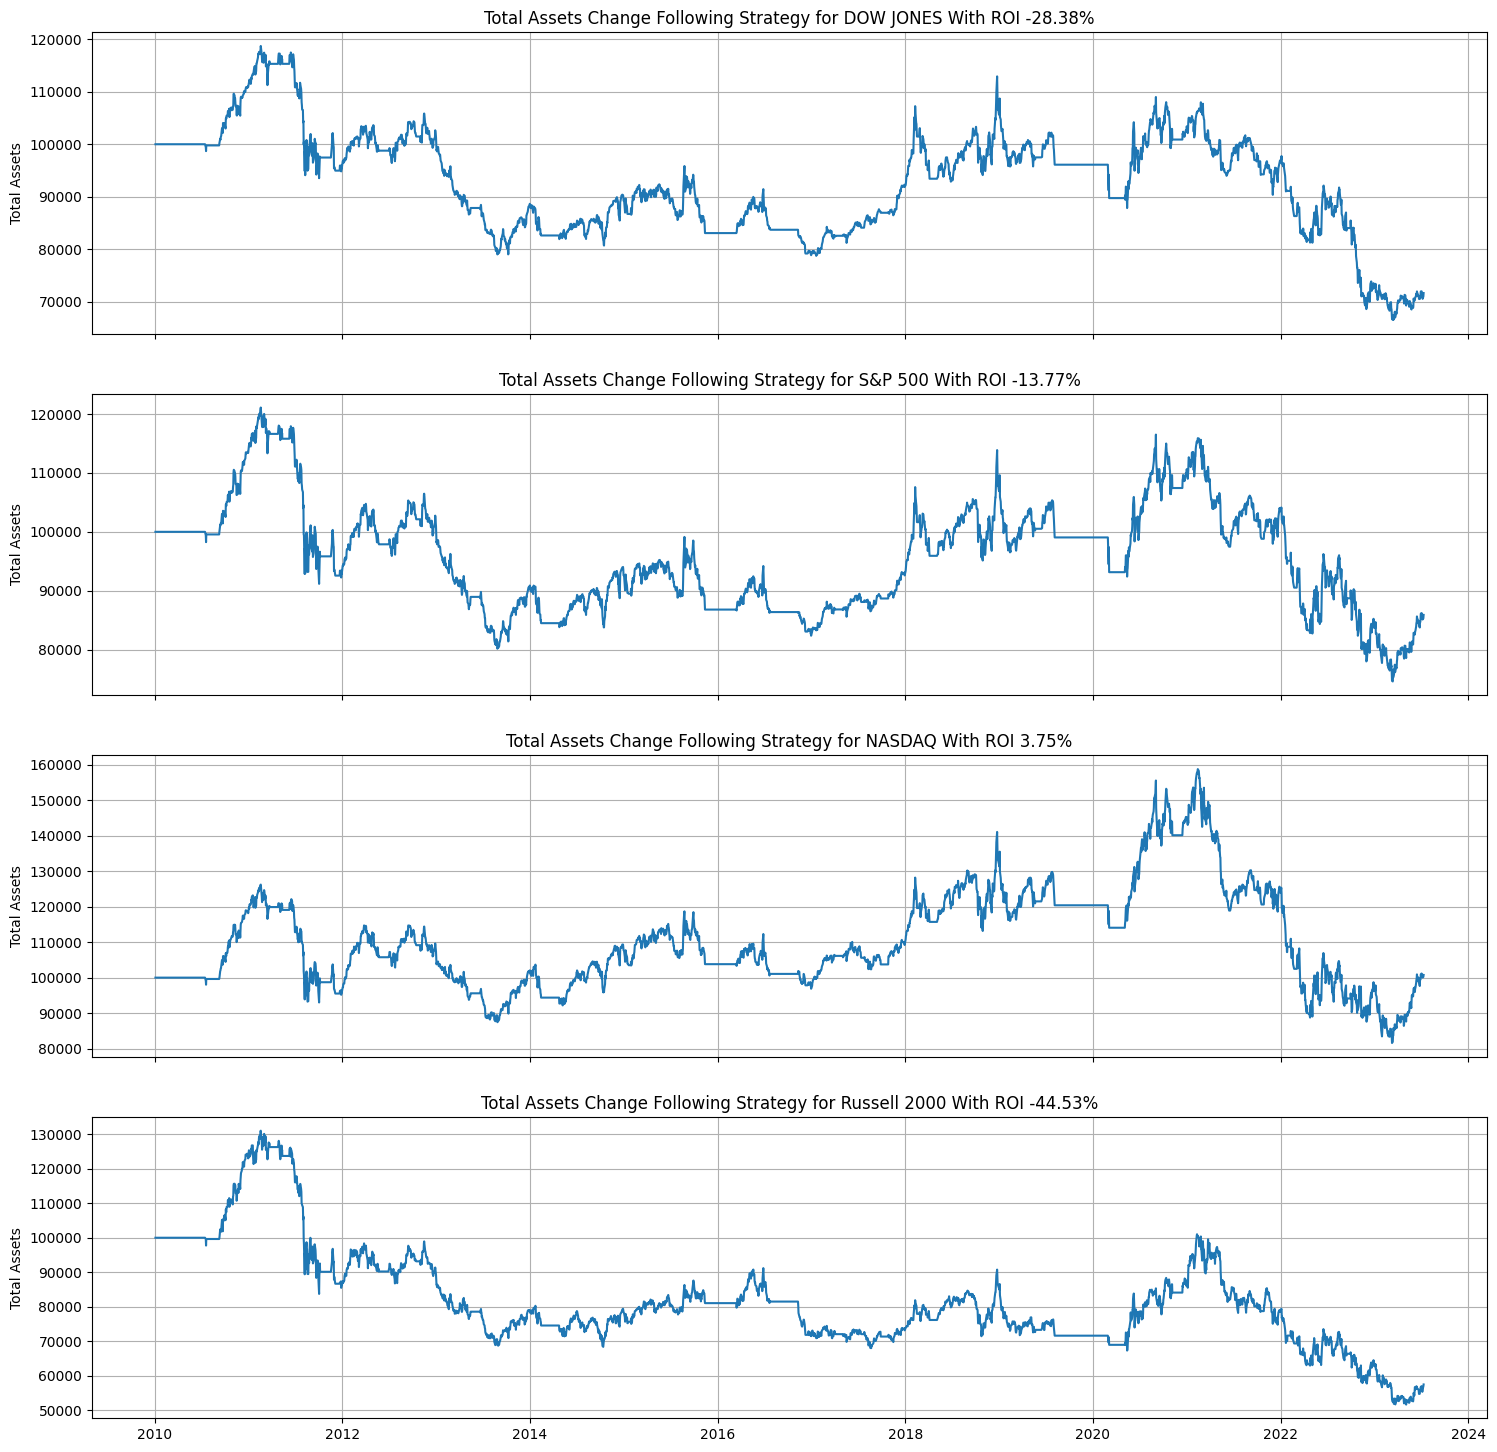

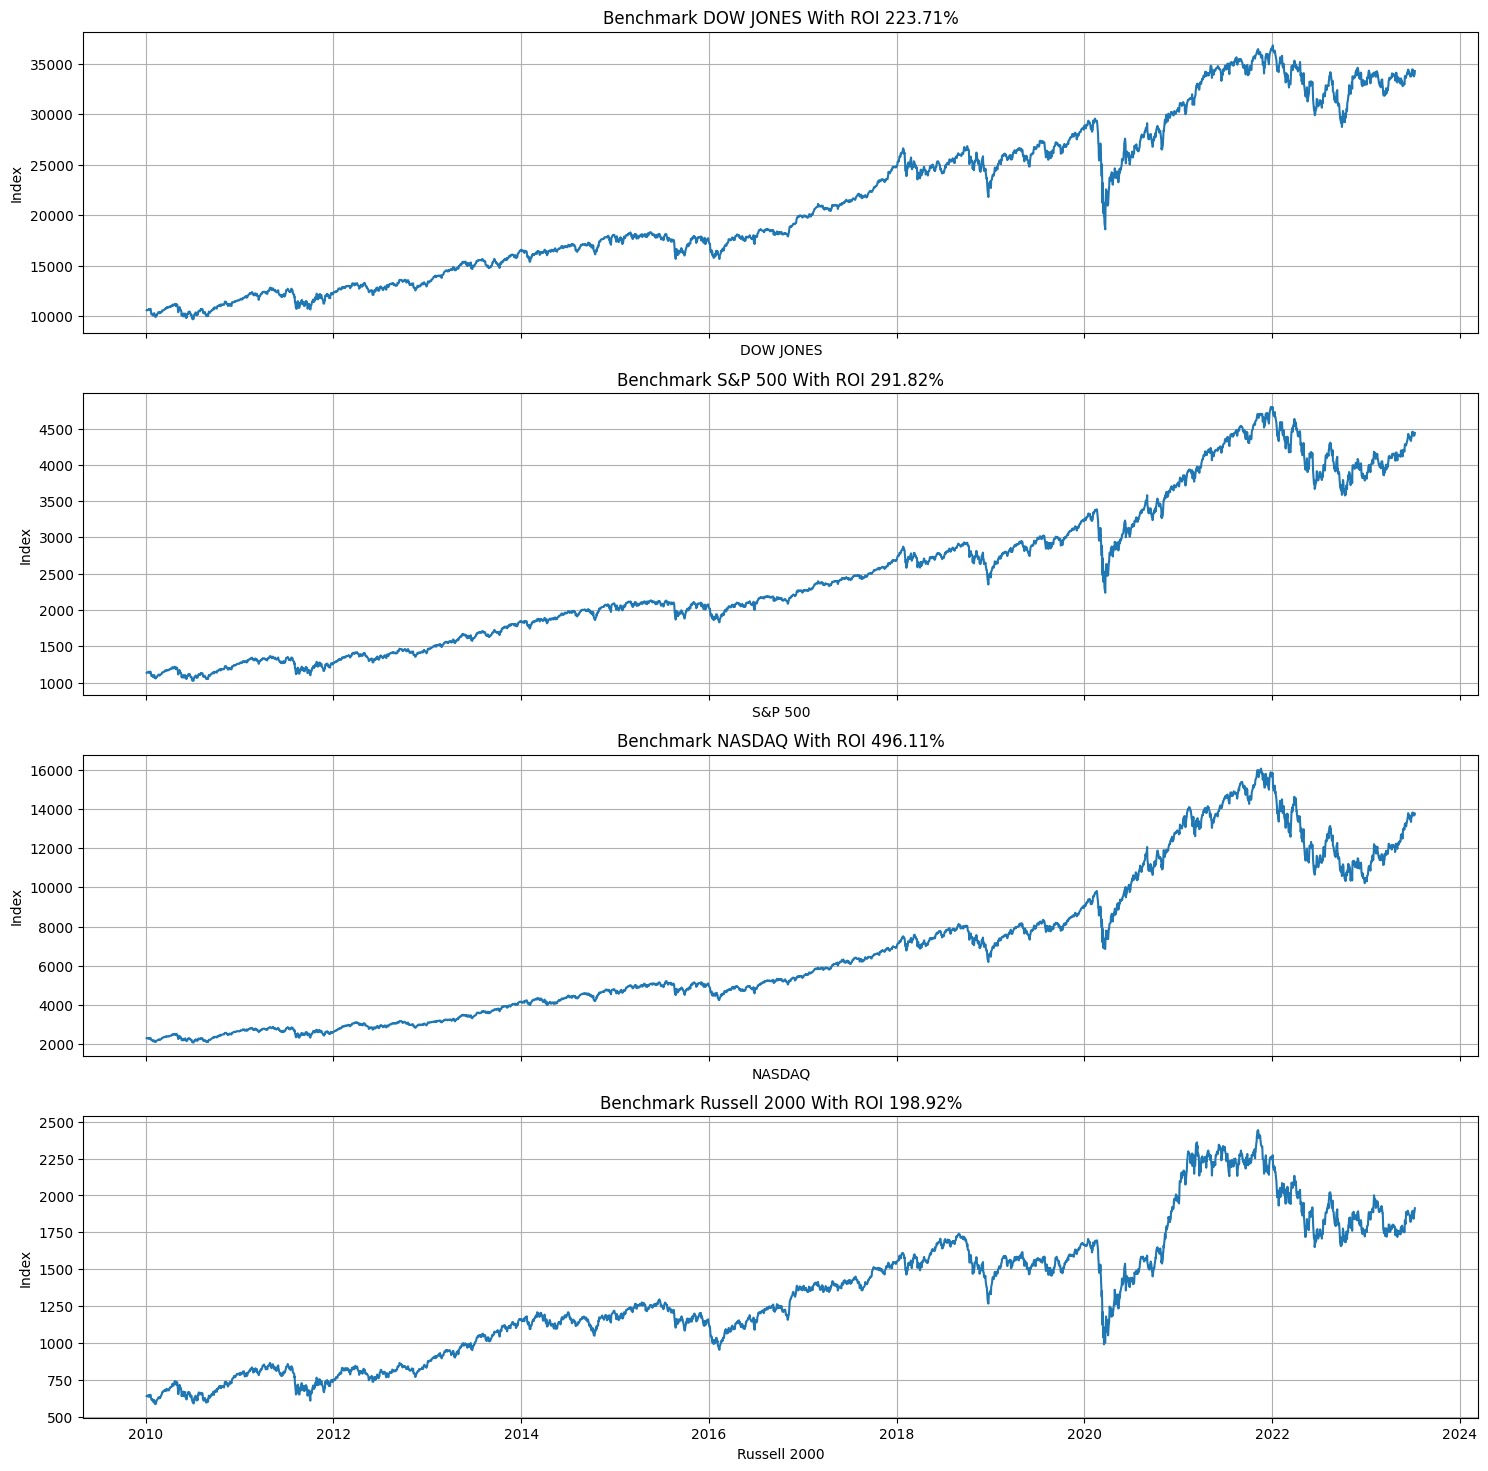

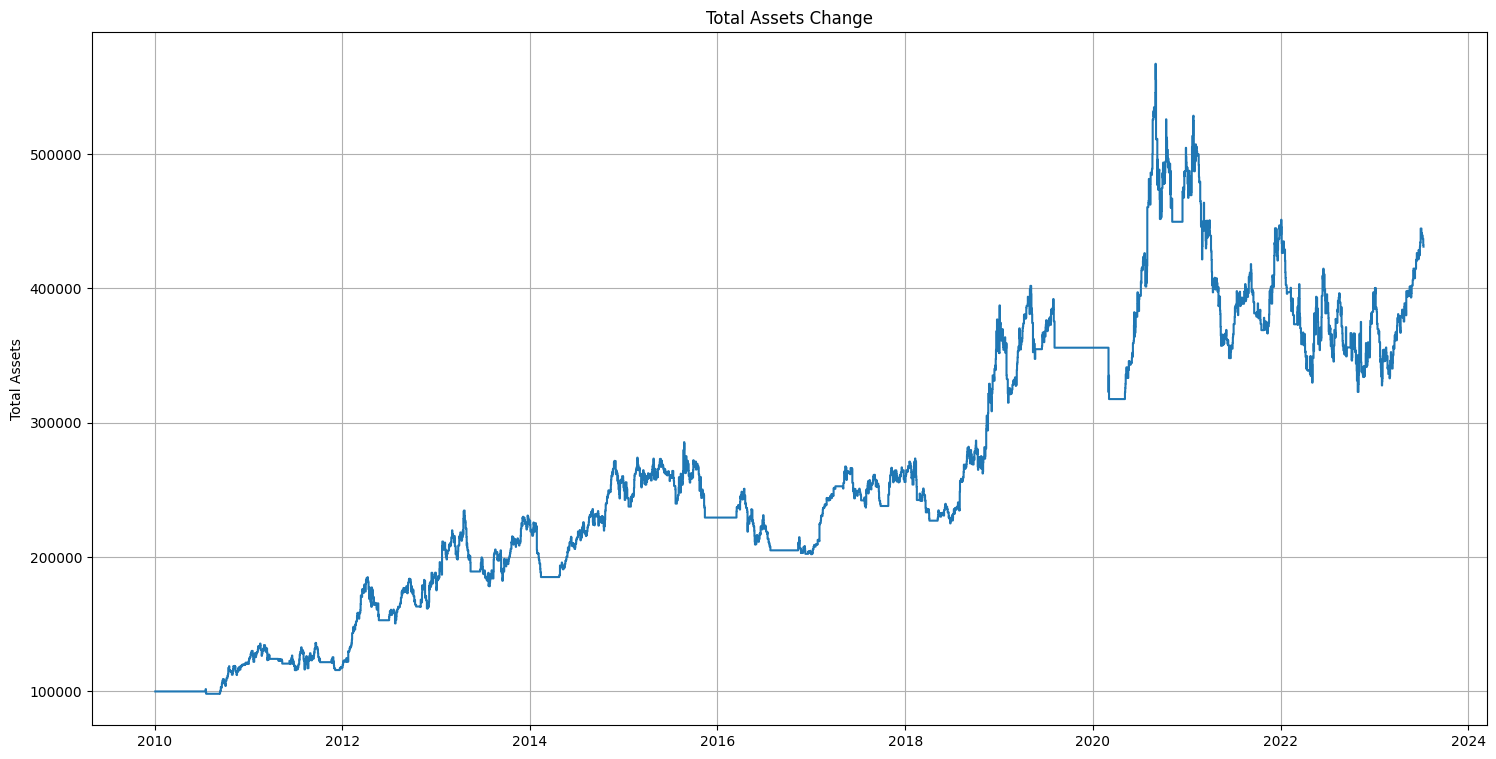

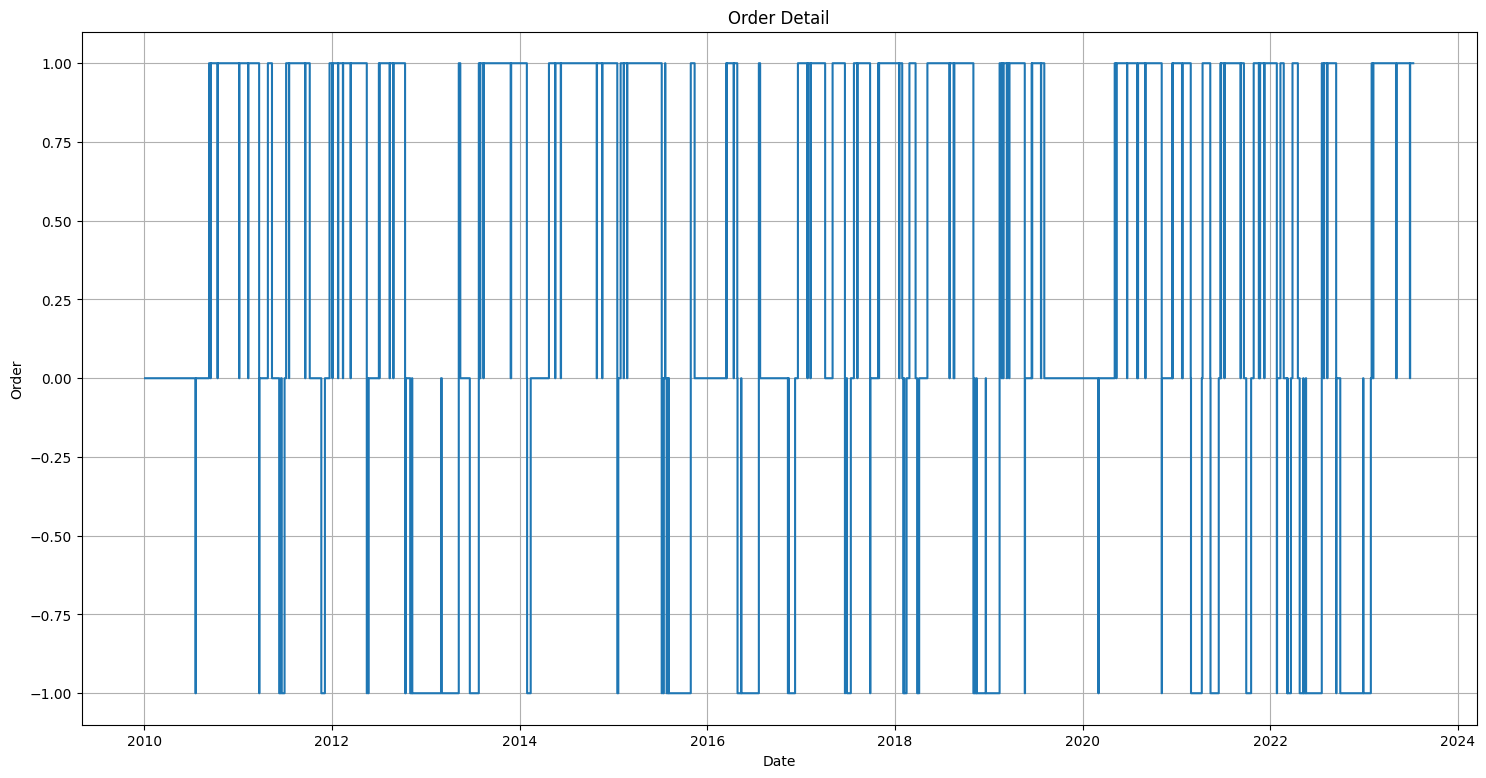

In [13]:
eval(stock)